In [1]:
# Import dependencies
import numpy as np
from numpy import newaxis
import pandas as pd 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Enter in how many steps we will enroll the network.

Enrol_window = 100

print ('enroll window set to', Enrol_window )

enroll window set to 100


In [3]:
# Support functions
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [15]:
# Upload CSV file
from google.colab import files
uploaded = files.upload()

Saving eth_all_features.csv to eth_all_features (3).csv


In [26]:
# Read Eth data
dataset = pd.read_csv('eth_all_features.csv', index_col='Unnamed: 0', parse_dates=True)
dataset.tail()

,Open,High,Low,Close,Volume,Personal Saving %,Close/Last,open,close,low,high,avgGas,nlikes,nretweets,compound,neg,neu,pos
2017-11-15,337.963989,340.911987,329.812988,333.356995,722665984,7.0,2564.62,0.1,20.0,0.1,60.0,57898.769541,3.261106,2.833403,0.098748,0.029318,0.903320,0.067360
2017-11-14,316.763000,340.177002,316.763000,337.631012,1069680000,7.0,2578.87,30.0,1.0,0.1,35.0,77198.609591,2.898046,2.153568,0.155619,0.030826,0.877397,0.091771
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,7.0,2584.84,4.0,1.0,0.1,50.0,68732.650465,3.146906,3.628248,0.103907,0.029216,0.901205,0.069577
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,7.0,2582.30,8.0,0.0,0.0,34.0,62459.741726,2.460854,2.444617,0.074516,0.053909,0.869239,0.076842
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,7.0,2584.62,4.0,20.0,0.1,60.0,51382.905682,2.580446,2.625297,0.086666,0.041577,0.887715,0.070710


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  if __name__ == '__main__':


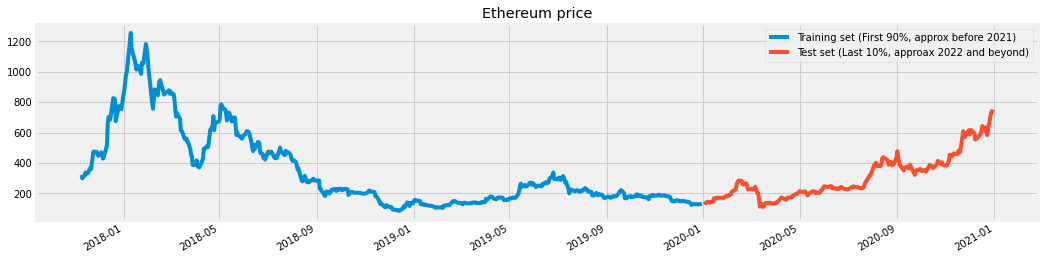

In [31]:
# Prepare the dataset, note that the eth price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case ethereum price
# Selected 'Close' (eth price at closing) attribute for prices. Let's see what it looks like

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window, True)

dataset["Close"][:'2019'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2020':].plot(figsize=(16,4),legend=True) # 20% is used for training data which is approx 2022 data
plt.legend(['Training set (First 80%, approx before 2021)','Test set (Last 20%, approax 2022 and beyond)'])
plt.title('Ethereum price')
plt.show()

In [32]:
# The same LSTM model I would like to test, lets see if the sinus prediction results can be matched

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 50)           7800      
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_4 (GRU)                 (None, 100)               45300     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53,201
Trainable params: 53,201
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

Epoch 1/5
2/2 [==============================] - 8s 937ms/step - loss: 1.0042 - val_loss: 0.3466
Epoch 2/5
2/2 [==============================] - 1s 320ms/step - loss: 0.6146 - val_loss: 0.1761
Epoch 3/5
2/2 [==============================] - 1s 309ms/step - loss: 0.3265 - val_loss: 0.0893
Epoch 4/5
2/2 [==============================] - 1s 314ms/step - loss: 0.1323 - val_loss: 0.1065
Epoch 5/5
2/2 [==============================] - 1s 290ms/step - loss: 0.0755 - val_loss: 0.2019


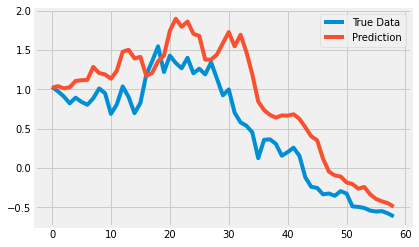

In [34]:
# Model and predict the eth price
predicted_eth_price = model.predict(feature_test)
plot_results(predicted_eth_price,label_test)

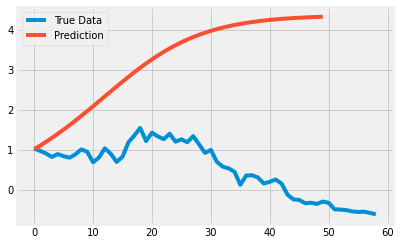

In [35]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
plot_results_multiple(predictions, label_test, 50) 